# Coffea Plotting Demo

In [1]:
from __future__ import print_function, division

import numpy as np
import uproot
import uproot_methods
import awkward

# histogram creation and manipulation
from coffea import hist

# nbagg is the interactive matplotlib backend
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
# let's borrow some example data from uproot
# See https://mybinder.org/v2/gh/scikit-hep/uproot/master?filepath=binder%2Ftutorial.ipynb
!curl -O http://scikit-hep.org/uproot/examples/HZZ.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  212k  100  212k    0     0   216k      0 --:--:-- --:--:-- --:--:--  216k


In [3]:
fin = uproot.open("HZZ.root")
tree = fin["events"]

In [4]:
# let's build the lepton arrays back into objects
# in the future, some of this verbosity can be reduced
arrays = {k.replace('Electron_', ''): v for k,v in tree.arrays("Electron_*", namedecode='ascii').items()}
p4 = uproot_methods.TLorentzVectorArray.from_cartesian(
    arrays.pop('Px'),
    arrays.pop('Py'),
    arrays.pop('Pz'),
    arrays.pop('E'),
)
electrons = awkward.JaggedArray.zip(p4=p4, **arrays)

arrays = {k.replace('Muon_', ''): v for k,v in tree.arrays("Muon_*", namedecode='ascii').items()}
p4 = uproot_methods.TLorentzVectorArray.from_cartesian(
    arrays.pop('Px'),
    arrays.pop('Py'),
    arrays.pop('Pz'),
    arrays.pop('E'),
)
muons = awkward.JaggedArray.zip(p4=p4, **arrays)

print("Avg. electrons/event:", electrons.counts.sum()/tree.numentries)
print("Avg. muons/event:", muons.counts.sum()/tree.numentries)

Avg. electrons/event: 0.07063197026022305
Avg. muons/event: 1.579925650557621


In [5]:
# Show electrons in the first event with some
electrons[electrons.counts > 0][0].tolist()

[{'p4': TLorentzVector(-82.592, 41.093, -363.75, 375.27),
  'Charge': -1,
  'Iso': 1.0901432037353516},
 {'p4': TLorentzVector(4.1628, -23.219, -66.384, 70.45),
  'Charge': 1,
  'Iso': 4.6292033195495605}]

In [6]:
# Two types of axes exist presently: bins and categories
lepton_kinematics = hist.Hist("Events",
                              hist.Cat("flavor", "Lepton flavor"),
                              hist.Bin("pt", "$p_{T}$", 19, 10, 100),
                              hist.Bin("eta", "$\eta$", [-2.5, -1.4, 0, 1.4, 2.5]),
                             )

# Pass keyword arguments to fill, all arrays must be flat numpy arrays
# User is responsible for ensuring all arrays have same jagged structure!
lepton_kinematics.fill(flavor="electron", pt=electrons['p4'].pt.flatten(), eta=electrons['p4'].eta.flatten())
lepton_kinematics.fill(flavor="muon", pt=muons['p4'].pt.flatten(), eta=muons['p4'].eta.flatten())

<IPython.core.display.Javascript object>


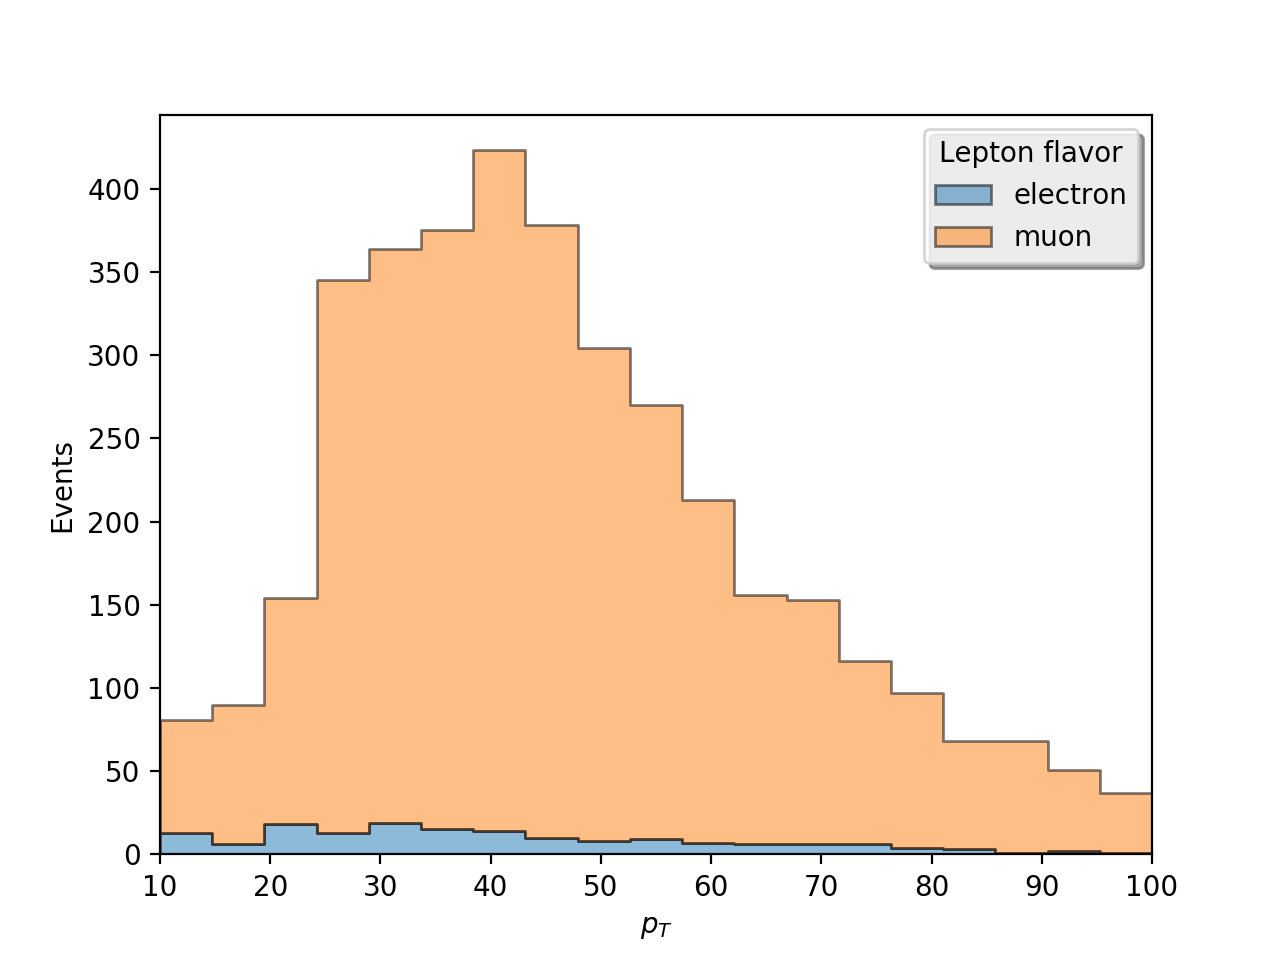

In [7]:
# looking at lepton pt for all eta
lepton_pt = lepton_kinematics.project("eta", overflow='under')

fig, ax, primitives = hist.plot1d(lepton_pt, overlay="flavor", stack=True,
                                  fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3)})
# all matplotlib primitives are returned, in case one wants to tweak them
# e.g. maybe you really miss '90s graphics...
primitives['legend'].shadow = True

<IPython.core.display.Javascript object>


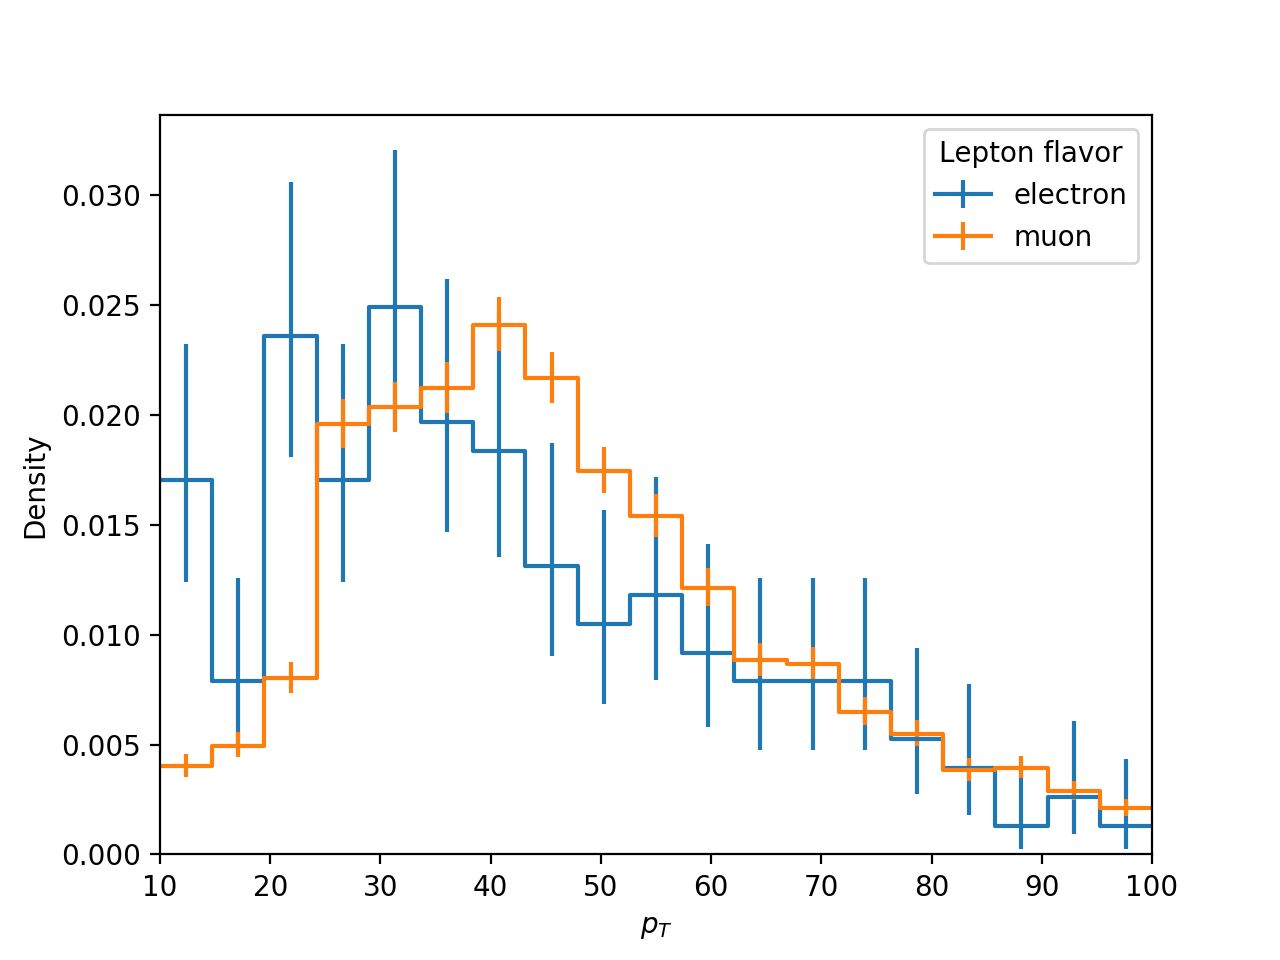

In [8]:
# Clearly the yields are much different, are the shapes similar?
lepton_pt.label = "Density"
fig, ax, primitives = hist.plot1d(lepton_pt, overlay="flavor", density=True)
# ...somewhat, maybe electrons are a bit softer

<IPython.core.display.Javascript object>


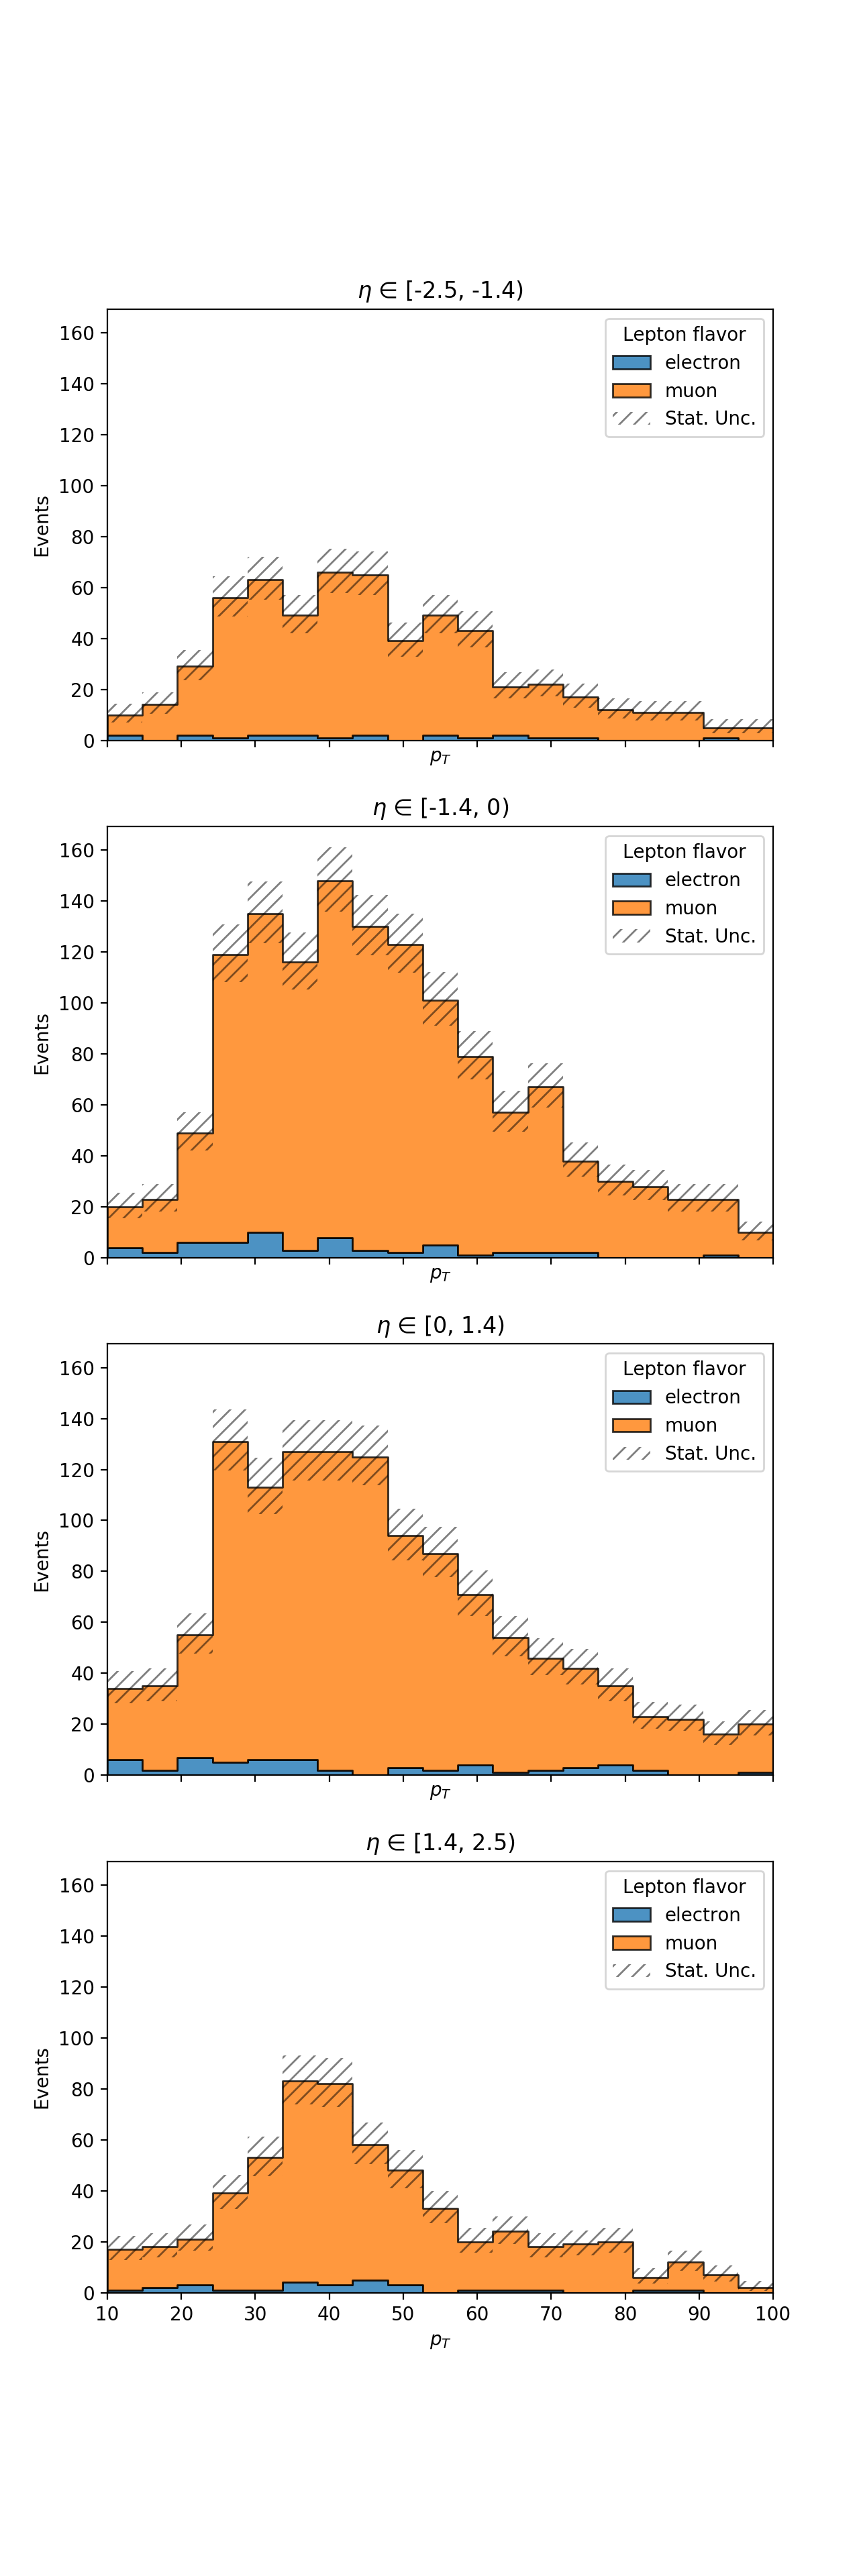

In [9]:
# Let's stack them, after defining some nice styling
stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,.5)}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
# maybe we want to compare different eta regions
# plotgrid accepts row and column axes, and creates a grid of 1d plots as appropriate
fig, ax = hist.plotgrid(lepton_kinematics, row="eta", overlay="flavor", stack=True,
                                  fill_opts=stack_fill_opts,
                                  error_opts=stack_error_opts,
                                 )

In [10]:
# Add some pseudodata to a pt histogram so we can make a nice data/mc plot
pthist = lepton_kinematics.sum('eta')
bin_values = pthist.axis('pt').centers()
poisson_means = pthist.sum('flavor').values()[()]
values = np.repeat(bin_values, np.random.poisson(poisson_means))
pthist.fill(flavor='pseudodata', pt=values)

# Set nicer labels, by accessing the string bins' label property
pthist.axis('flavor').index('electron').label = 'e Flavor'
pthist.axis('flavor').index('muon').label = r'$\mu$ Flavor'
pthist.axis('flavor').index('pseudodata').label = r'Pseudodata from e/$\mu$'

# using regular expressions on flavor name to select just the data
# another method would be to fill a separate data histogram
import re
notdata = re.compile('(?!pseudodata)')

<IPython.core.display.Javascript object>


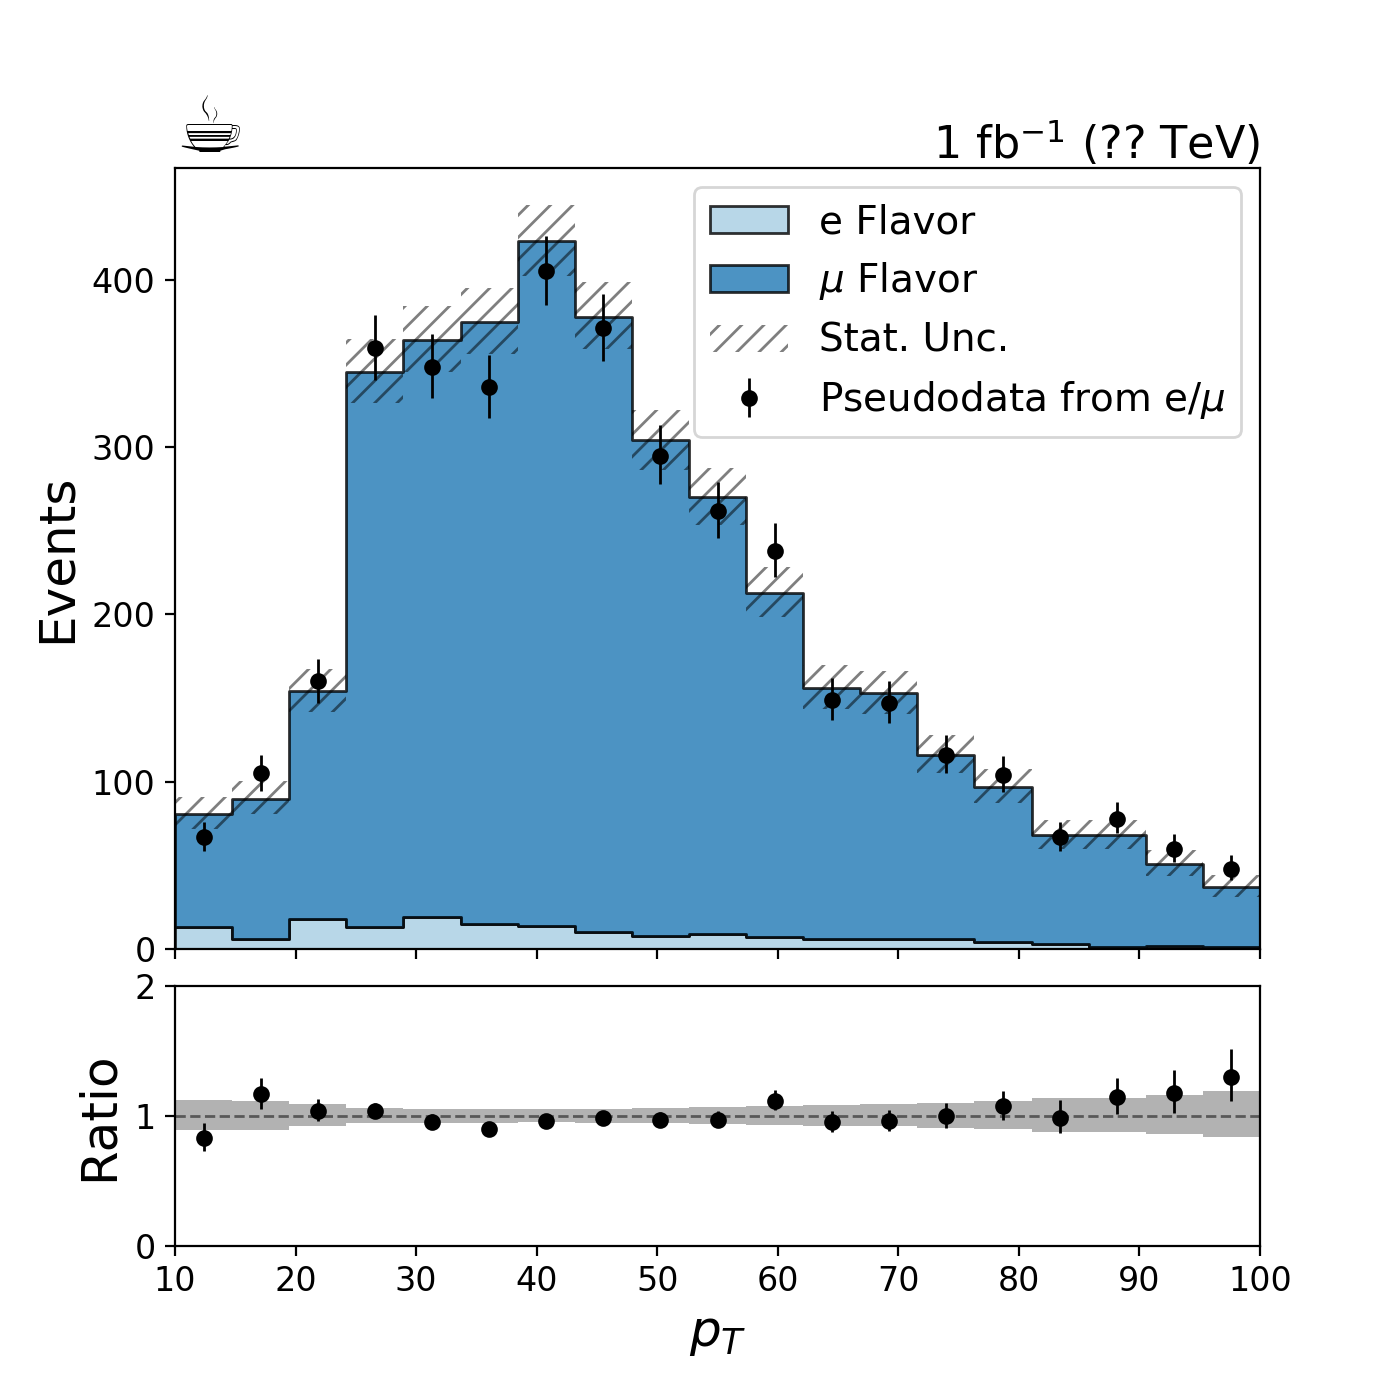

In [11]:
# make a nice ratio plot
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
fig, (ax, rax) = plt.subplots(2, 1, figsize=(7,7), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

# Here is an example of setting up a color cycler to color the various fill patches
# http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
from cycler import cycler
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
ax.set_prop_cycle(cycler(color=colors))

fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'///',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

hist.plot1d(pthist[notdata], 
            overlay="flavor", 
            ax=ax,
            clear=False,
            stack=True, 
            line_opts=None,
            fill_opts=fill_opts,
            error_opts=error_opts
           )
hist.plot1d(pthist['pseudodata'],
            overlay="flavor",
            ax=ax,
            clear=False,
            error_opts=data_err_opts
           )

ax.autoscale(axis='x', tight=True)
ax.set_ylim(0, None)
ax.set_xlabel(None)
leg = ax.legend()

hist.plotratio(pthist['pseudodata'].sum("flavor"), pthist[notdata].sum("flavor"), 
               ax=rax,
               error_opts=data_err_opts, 
               denom_fill_opts={},
               guide_opts={},
               unc='num'
              )
rax.set_ylabel('Ratio')
rax.set_ylim(0,2)

coffee = plt.text(0., 1., u"☕",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"1 fb$^{-1}$ (?? TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

In [12]:
# ok lets make some Z candidates
ee_cands = electrons.choose(2)
mm_cands = muons.choose(2)

# filter opposite-sign
good_ee = ee_cands.i0['Charge'] + ee_cands.i1['Charge'] == 0
ee_p4 = ee_cands.i0['p4'] + ee_cands.i1['p4']
good_mm = mm_cands.i0['Charge']*mm_cands.i1['Charge'] == -1
mm_p4 = mm_cands.i0['p4'] + mm_cands.i1['p4']

<IPython.core.display.Javascript object>


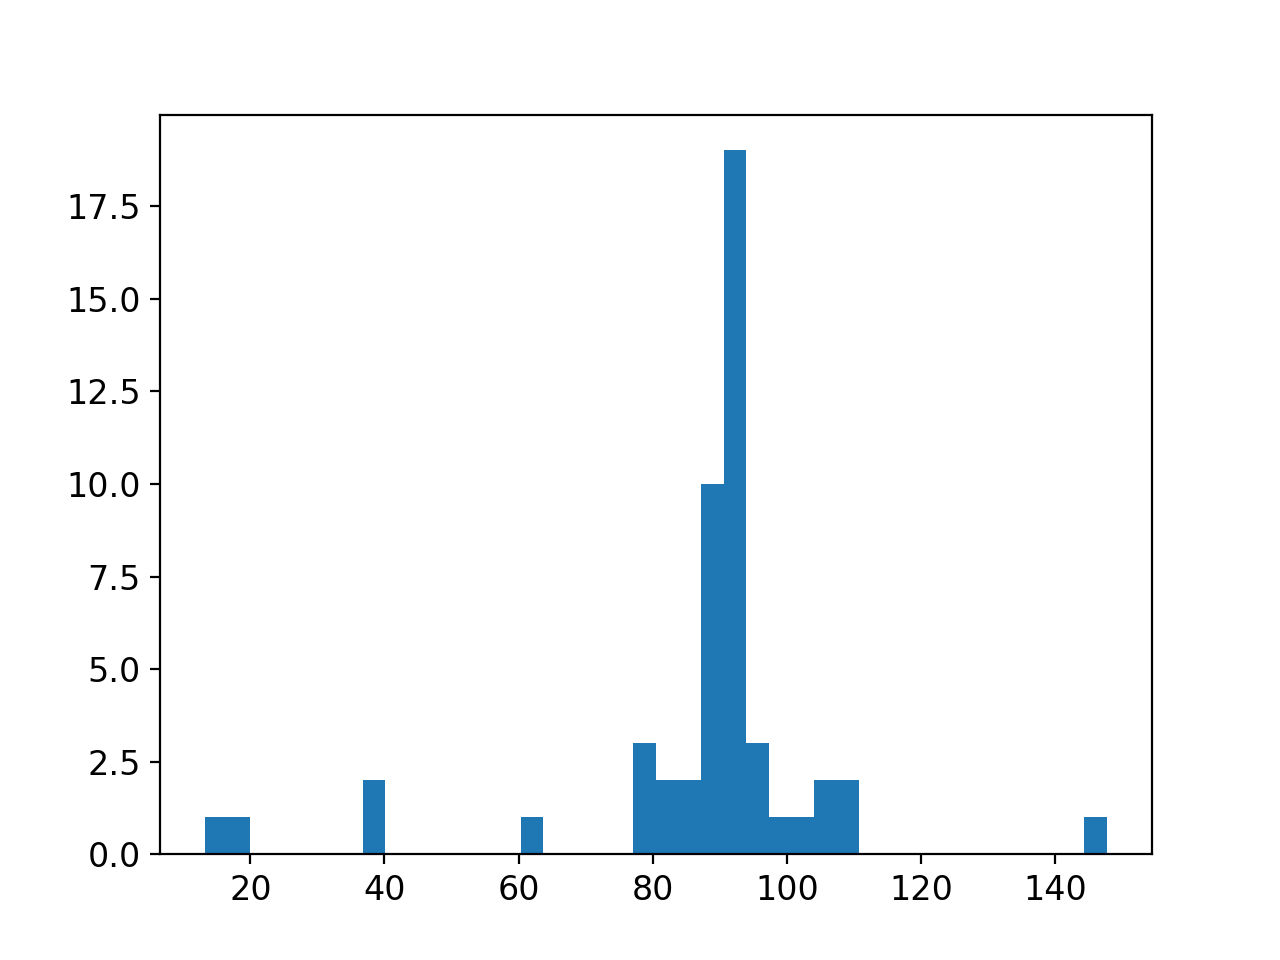

In [13]:
# we can also use matplotlib builtin functions for histogramming, if preferred
fig, ax = plt.subplots(1,1)
_ = plt.hist(ee_p4.mass[good_ee].flatten(), bins=40)

In [14]:
# for many plot styles, one can and should write the matplotlib routine themselves
# let's make a scatter plot of the leading and subleading Z candidate (by delta-mass)
# but first we have to calculate the right combinations (which is a bit difficult in pure columnar)

# CAUTION: composing combinatorics does not check for duplicates!
wrong = mm_cands.choose(2)
print(np.unique(wrong.counts))

zz_4e = electrons.choose(4)
zz_4m = muons.choose(4)
print(np.unique(zz_4m.counts))

# for the ee+mm channel, composing is not an issue as the pairs are already mutually exclusive
zz_2e2m = ee_cands.cross(mm_cands)

[ 0  3 15]
[0 1]


In [15]:
ZMASS = 91.1876

def massmetric(cands, i, j):
    z1mass = (cands['%d' % i]['p4'] + cands['%d' % j]['p4']).mass
    k, l = set(range(4)) - {i, j}
    z2mass = (cands['%d' % k]['p4'] + cands['%d' % l]['p4']).mass
    deltam = np.abs(z1mass - ZMASS)
    deltaq = np.abs(cands['%d' % i]['Charge'] + cands['%d' % j]['Charge'])
    # inflate deltam to absurd number if charge sum is nonzero
    return z1mass, z2mass, deltam + 1e10*deltaq
    

def bestcombination(zzcands):
    good_charge = sum(zzcands[str(i)]['Charge'] for i in range(4)) == 0
    good_event = good_charge.sum() == 1
    # this downselection keeps all events where exactly one candidate satisfies the requirement
    # but does not reduce the number of events, i.e. len(zz_4m) stays the same
    zzcands = zzcands[good_charge*good_event][:,:1]
    if zzcands.counts.sum() == 0:
        # empty array (because a bug in concatenate makes it fail on empty arrays)
        empty = awkward.JaggedArray.fromcounts(np.zeros(len(zzcands), dtype='i'), [])
        return empty, empty
    # now we have to check the permutations of leptons for closest mass to Z boson
    # only 4 of these 6 permutations are valid charge pairs, but its easier
    # to compare them all, and assign a large delta mass rather than figure out which
    # are valid beforehand
    z1mass = []
    z2mass = []
    iperm = []
    for i,j in [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]:
        z1, z2, idx = massmetric(zzcands, i, j)
        z1mass.append(z1)
        z2mass.append(z2)
        iperm.append(idx)

    z1mass = awkward.JaggedArray.concatenate(z1mass, axis=1)
    z2mass = awkward.JaggedArray.concatenate(z2mass, axis=1)
    iperm = awkward.JaggedArray.concatenate(iperm, axis=1)
    z1mass = z1mass[iperm.argmin()]
    z2mass = z2mass[iperm.argmin()]
    return z1mass, z2mass

    
z1_4m, z2_4m = bestcombination(zz_4m)
z1_4e, z2_4e = bestcombination(zz_4e)

# for 2e2m its a bit simpler
good_charge = (zz_2e2m.i0['Charge'] + zz_2e2m.i1['Charge'] == 0) & (zz_2e2m.i2['Charge'] + zz_2e2m.i3['Charge'] == 0)
good_event = good_charge.sum() == 1
zz_2e2m = zz_2e2m[good_event*good_charge][:,:1]
za_2e2m, zb_2e2m, deltam_a = massmetric(zz_2e2m, 0, 1)
_, _, deltam_b = massmetric(zz_2e2m, 2, 3)
# this is a good place for awkward.where, but its not available yet
z_2e2m = awkward.JaggedArray.concatenate([za_2e2m, zb_2e2m], axis=1)
deltam = awkward.JaggedArray.concatenate([deltam_a, deltam_b], axis=1)
z1_2e2m = z_2e2m[deltam.argmin()]
z2_2e2m = z_2e2m[deltam.argmax()]

# see if any events had candidates in multiple categories
# this is extremely rare, but if it happens we would have again to choose a preferred category
print("Max candidates/event:", np.max(z1_4e.counts + z1_4m.counts + z1_2e2m.counts))

Max candidates/event: 1


<IPython.core.display.Javascript object>


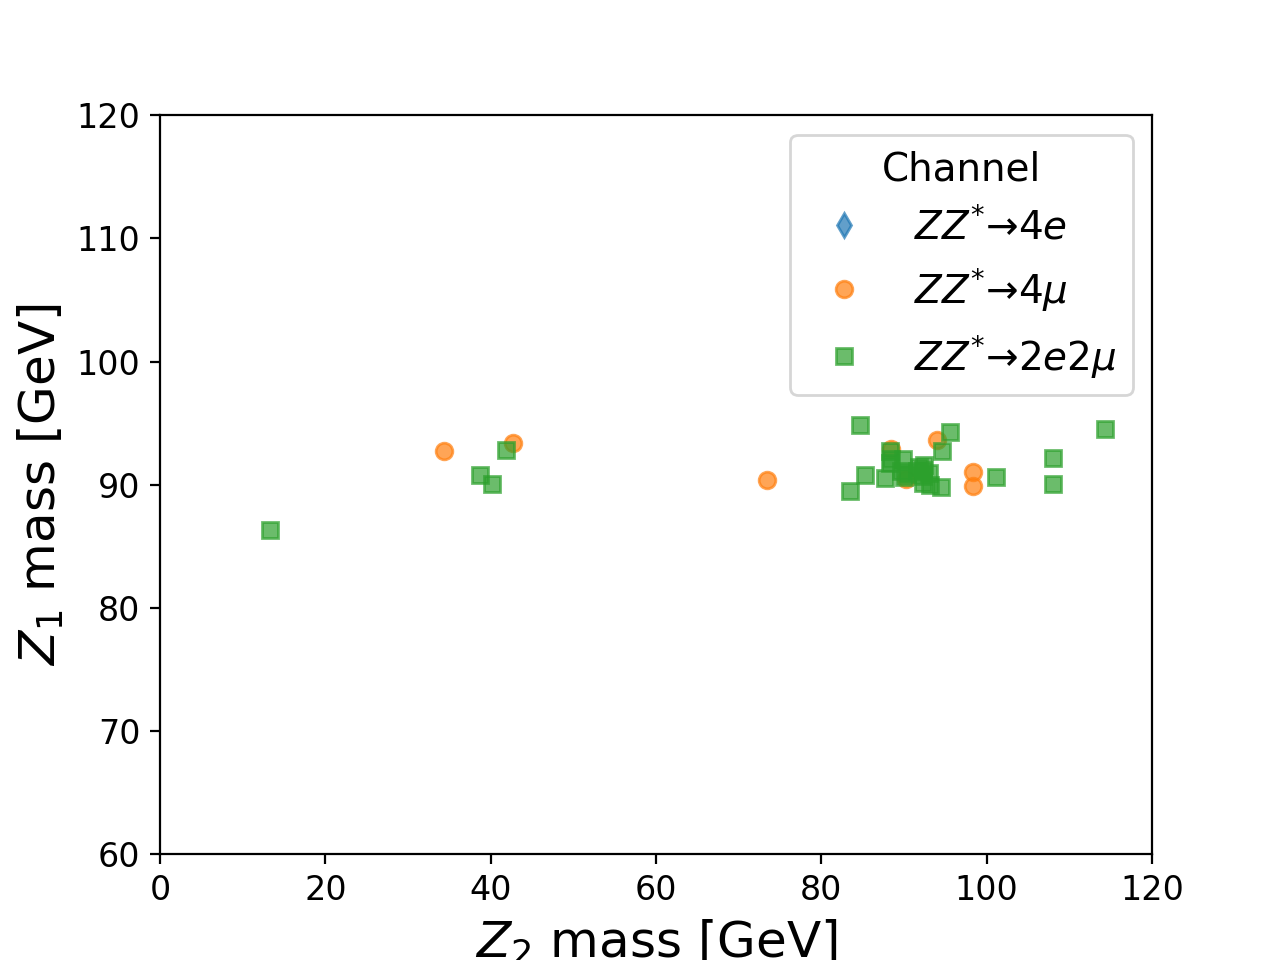

Text(0, 0.5, '$Z_1$ mass [GeV]')

In [16]:
fig, ax = plt.subplots()

common = {'linestyle': 'none', 'alpha': 0.7}
ax.plot(z2_4e.flatten(), z1_4e.flatten(), marker='d', label=r'$ZZ^{*}\to 4e$', **common)
ax.plot(z2_4m.flatten(), z1_4m.flatten(), marker='o', label=r'$ZZ^{*}\to 4\mu$', **common)
ax.plot(z2_2e2m.flatten(), z1_2e2m.flatten(), marker='s', label=r'$ZZ^{*}\to 2e2\mu$', **common)
ax.legend(title='Channel')
ax.set_xlim(0, 120)
ax.set_ylim(60, 120)
ax.set_xlabel('$Z_2$ mass [GeV]')
ax.set_ylabel('$Z_1$ mass [GeV]')

<IPython.core.display.Javascript object>


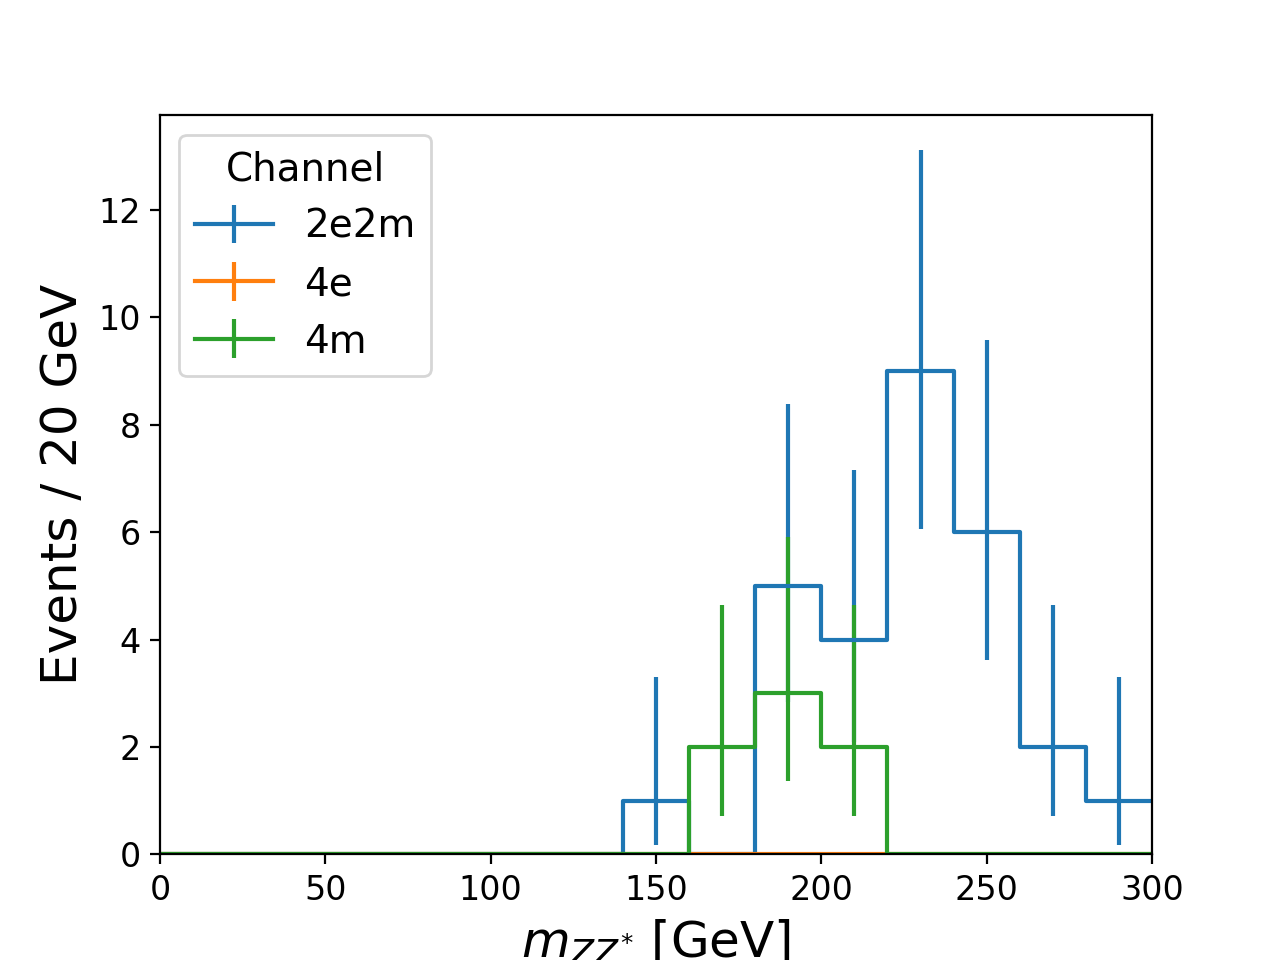

/Users/lagray/coffea/coffea/binder/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


In [17]:
# What a curious sample, it looks like more of a ZZ background sample
# Let's check the 4l mass

# for some reason, sum(...) doesn't work, try another route
from functools import reduce
from operator import add

hmass = hist.Hist("Events / 20 GeV",
                  hist.Cat("channel", "Channel"),
                  hist.Bin("mass", r"$m_{ZZ^{*}}$ [GeV]", 15, 0, 300)
                 )
hmass.fill(channel="4e", mass=reduce(add, (zz_4e[str(i)]['p4'] for i in range(4))).mass.flatten())
hmass.fill(channel="4m", mass=reduce(add, (zz_4m[str(i)]['p4'] for i in range(4))).mass.flatten())
hmass.fill(channel="2e2m", mass=reduce(add, (zz_2e2m[str(i)]['p4'] for i in range(4))).mass.flatten())

fig, ax, _ = hist.plot1d(hmass, overlay='channel')